<a href="https://colab.research.google.com/github/oladimeji-kazeem/currency-exchange-rate-predictor/blob/master/Exchange_Rate_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from fredapi import Fred
from getpass import getpass

In [5]:
# Secure API key input
fred_api_key = getpass("Enter your FRED API key: ")
fred = Fred(api_key=fred_api_key)

Enter your FRED API key: ··········


In [6]:
# Load FRED data
eur_usd = fred.get_series('DEXUSEU')         # EUR to USD exchange rate
interest_rate = fred.get_series('FEDFUNDS')  # Federal Funds Rate
cpi = fred.get_series('CPIAUCSL')            # Consumer Price Index

In [7]:
# Combine and clean data
df = pd.concat([eur_usd, interest_rate, cpi], axis=1)
df.columns = ['rate', 'interest_rate', 'cpi']
df.index = pd.to_datetime(df.index)
df.dropna(inplace=True)

In [8]:
# Create lag features (window of 3)
for i in range(1, 4):
    df[f'rate_lag{i}'] = df['rate'].shift(i)
df.dropna(inplace=True)

In [9]:
# Define features and scale them
feature_cols = ['rate_lag1', 'rate_lag2', 'rate_lag3', 'interest_rate', 'cpi']
X = df[feature_cols]
y = df['rate'].values.reshape(-1, 1)

In [10]:
# Scale features
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

In [11]:
# Scale target
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y).flatten()

In [12]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)

In [13]:
# Define and train MLP model
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    max_iter=1000,
    early_stopping=True,
    random_state=42
)
mlp.fit(X_train, y_train)

MLPRegressor(alpha=0.001, early_stopping=True, hidden_layer_sizes=(64, 64),
             max_iter=1000, random_state=42)

In [14]:
# Predict and inverse transform
y_pred_scaled = mlp.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

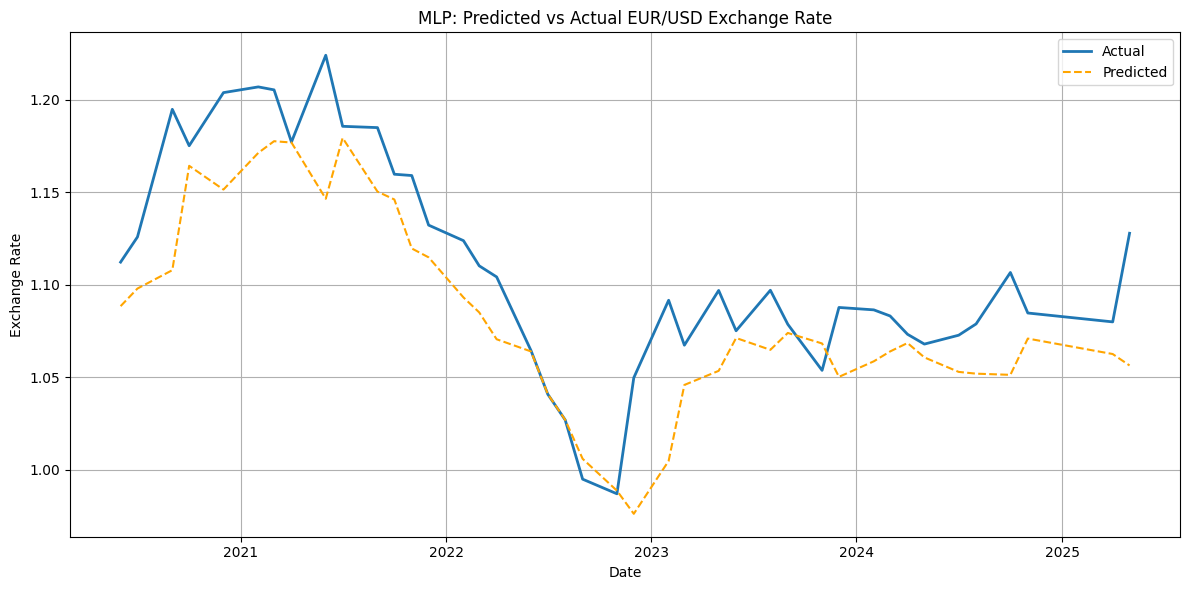

In [15]:
# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual', linewidth=2)
plt.plot(df.index[-len(y_test):], y_pred, label='Predicted', linestyle='--', color='orange')
plt.title('MLP: Predicted vs Actual EUR/USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Print evaluation
mse = mean_squared_error(y_test_actual, y_pred)
print(f"Mean Squared Error: {mse:.6f}")

Mean Squared Error: 0.001339
